In [89]:
from dolfin import *
from matplotlib import pyplot as plt

In [90]:
# Create mesh and define function space

length, depth = 3000, 300
num_ele_along_depth = 10
ele_size = depth/num_ele_along_depth
mesh = RectangleMesh(Point(0, 0), Point(length, depth),
                     int(length/ele_size), int(depth/ele_size))
V = VectorFunctionSpace(mesh, "Lagrange", 1)

In [91]:

# Mark boundary subdomians
clamped_boundary = CompiledSubDomain("near(x[0],0)")
load_boundary = CompiledSubDomain("near(x[0],3000)")

# Define Dirichlet boundary (x = 0 or x = 1)
c = Expression(("0.0", "0.0"), degree=1)
r = Expression(("-disp_step*t"), disp_step=1e-1, t=1, degree=1)

bcl = DirichletBC(V, c, clamped_boundary)
bcr = DirichletBC(V.sub(1), r, load_boundary)
bcs = [bcl, bcr]

# Define functions
du = TrialFunction(V)            # Incremental displacement
v = TestFunction(V)             # Test function
u = Function(V)                 # Displacement from previous iteration
B = Constant((0.0, 0.0))  # Body force per unit volume
T = Constant((0.0, 0.0))  # Traction force on the boundary

# Kinematics
d = u.geometric_dimension()
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient
C = F.T*F                   # Right Cauchy-Green tensor

# Invariants of deformation tensors
Ic = tr(C)
J = det(F)

# Elasticity parameters
E, nu = 104.0, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Stored strain energy density (compressible neo-Hookean model)
psi = (mu/2)*(Ic - 3) - mu*ln(J) + (lmbda/2)*(ln(J))**2

# Total potential energy
Pi = psi*dx - dot(B, u)*dx - dot(T, u)*ds

# Compute first variation of Pi (directional derivative about u in the direction of v)
F = derivative(Pi, u, v)

# Compute Jacobian of F
J = derivative(F, u, du)

# Compute solution
problem = NonlinearVariationalProblem(F, u, bcs, J)
solver = NonlinearVariationalSolver(problem)

prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = 1E-7
prm['newton_solver']['relative_tolerance'] = 1E-7
prm['newton_solver']['maximum_iterations'] = 1000
prm['newton_solver']['linear_solver'] = 'gmres'
prm['newton_solver']['preconditioner'] = 'hypre_euclid'
prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-7
prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-7
prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000

solver.solve()
print("The minimum displacement is: {0:6.3e} mm".format(u.vector().min()))

The minimum displacement is: -1.000e-01 mm


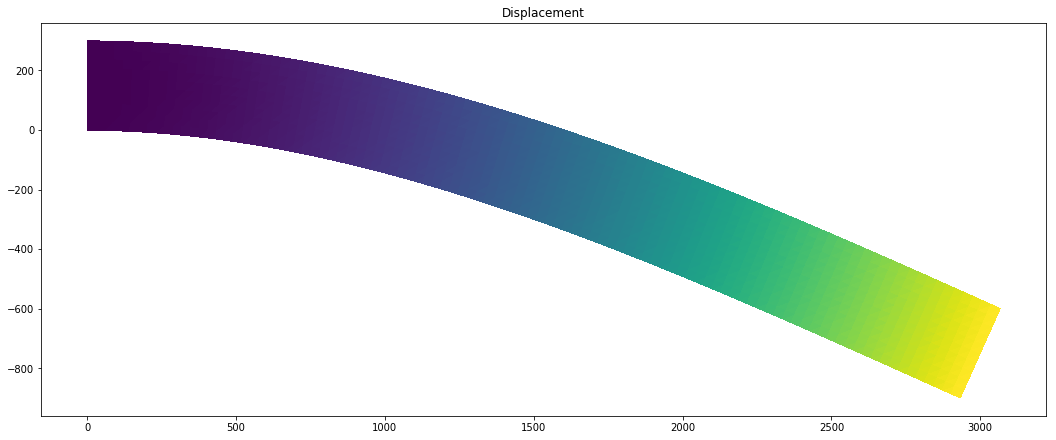

In [92]:
plt.figure(figsize=(18, 16))
# Plot solution
scale_factor = 9000
plot(u*scale_factor, title='Displacement', mode='displacement')